# Supplementary Figures

## Move this to separate script/module

In [2]:
import pandas as pd
import reframed


from sklearn.metrics.pairwise import pairwise_distances
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc
import seaborn as sns

from matplotlib import colors
import sys
sys.path.append("../functions_steadiercom/")
sys.path.append("../functions/")
import supplementary_process_data as process_data
import general_functions as general_func
import colors_community
import colors_MAGs

import steadiercom_samples_preprocessing as steadiercom_pre


import matplotlib.pyplot as plt
from matplotlib.pyplot import gcf
from reframed.cobra import auxotrophy


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
communityid2name_dict = {"CD_A":"Compost digestate - Avicel",
"CD_P":"Compost digestate - PASC",
"CD_X":"Compost digestate - Xylan",
"CM_A":"Cow manure - Avicel",
"CM_P":"Cow manure - PASC",
"CM_X":"Cow manure - Xylan",
"M_P":"Marshland soil - PASC",
"M_X":"Marshland soil - Xylan",
}


SC1_C = pd.read_csv("../output_30_08_24/steadiercom_sample_0.1.3/results/results_99_SC1_C.tsv",sep="\t")
SC2_C = pd.read_csv("../output_30_08_24/steadiercom_sample_0.1.3/results/results_99_SC2_C.tsv",sep="\t")
SC1_X = pd.read_csv("../output_30_08_24/steadiercom_sample_0.1.3/results/results_99_SC1_X.tsv",sep="\t")

steadier_sample = pd.concat([SC1_C,SC2_C,SC1_X])


steadier_sample = steadier_sample[(steadier_sample.rate>1e-6)].copy()
steadier_sample.mass_rate = steadier_sample.mass_rate*1000

In [5]:
all_mags_paper = general_func.read_allmags_data()
all_mags_paper_reduced,total_members_genus = general_func.all_mags_paper_genus(all_mags_paper,prefix=True)
all_mags_paper_reduced,total_members_family = general_func.all_mags_paper_family(all_mags_paper_reduced,prefix=True,combine=False)

In [6]:
steadier_sample = process_data.process_data(steadier_sample,all_mags_paper_reduced=all_mags_paper_reduced)

In [7]:
steadier_sample

,donor,receiver,compound,mass_rate,rate,frequency,community,medium,mass_rate*frequency,super_class,genus_donor,genus_receiver,family_donor,family_receiver
0,environment,CH13-bin.12,Cellulose (n=5 repeating units),24.814096,0.029943,1.00,CD_A,SC1_C,24.814096,oligosaccharides,environment,g_Fibro-01,environment,f_Fibrobacteraceae
1,environment,CH15-bin.0,Cellulose (n=5 repeating units),20.866583,0.025179,0.73,CD_P,SC1_C,15.232606,oligosaccharides,environment,g_DUOS01,environment,f_Treponemataceae
2,environment,CH15-bin.0,Cellulose (n=4 repeating units),19.279036,0.028922,0.18,CD_P,SC1_C,3.470226,oligosaccharides,environment,g_DUOS01,environment,f_Treponemataceae
3,environment,CH15-bin.0,Cellulose (n=3 repeating units),16.308954,0.032331,0.10,CD_P,SC1_C,1.630895,oligosaccharides,environment,g_DUOS01,environment,f_Treponemataceae
4,CH13-bin.12,environment,Acetic acid,14.176353,0.240099,1.00,CD_A,SC1_C,14.176353,carboxylic acids and anions,g_Fibro-01,environment,f_Fibrobacteraceae,environment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,CH9-bin.2,CH9-bin.4,Hydrogen sulfide,0.000165,0.000005,0.22,CM_X,SC1_X,0.000036,gases,g_Clostridium,g_Lentilactobacillus,f_Clostridiaceae,f_Lactobacillaceae
359,CH14-bin.4,CH14-bin.0,Hydrogen,0.000148,0.000073,0.01,CD_X,SC1_X,0.000001,gases,g_Desulfovibrio,g_Caproiciproducens,f_Desulfovibrionaceae,f_Acutalibacteraceae
360,CH3-bin.1,environment,Glycolaldehyde,0.000079,0.000001,1.00,M_X,SC1_X,0.000079,other,g_Clostridium_S,environment,f_Clostridiaceae,environment
361,CH14-bin.0,environment,Glycolaldehyde,0.000065,0.000001,0.11,CD_X,SC1_X,0.000007,other,g_Caproiciproducens,environment,f_Acutalibacteraceae,environment


In [8]:
model_uni = reframed.load_cbmodel("../input/universe_bacteria.xml")


## Production

### Production and realease to environment - community wise

In [9]:
cmap = colors_community.cmap_community()
cmap_lut = dict(zip(sorted(steadier_sample.community.unique()),cmap.colors))

**Process data**

In [10]:
steadier_sample_bar = steadier_sample.copy()
steadier_sample_production = steadier_sample_bar[steadier_sample_bar.receiver=="environment"].copy()
steadier_sample_production["community"]=steadier_sample_production["community"].map(lambda x:communityid2name_dict[x])
cmap_local = colors.ListedColormap([cmap_lut[community] for community in communityid2name_dict.keys()])

**Inner plot**

In [11]:
steadier_sample_production = steadier_sample_production[steadier_sample_production.compound.isin(["Acetic acid","CO2","L-Lactic acid","Ethanol","Formic acid","Isobutyric acid","Propionic acid","Butyric acid","Caproic acid","Hydrogen"])]
steadier_sample_prod_plot_df = steadier_sample_production.groupby(["community","compound"]).sum()["mass_rate*frequency"].unstack().fillna(0).T
steadier_prod_sum = steadier_sample_prod_plot_df.sum(axis=1)
sorter = steadier_prod_sum.sort_values().index
steadier_sample_prod_plot_df = steadier_sample_prod_plot_df.loc[sorter]

steadier_sample_prod_plot_df.plot(kind="bar",cmap=cmap_local,fontsize=12, rot=90,legend=False)
plt.xlabel('')
plt.savefig("Figures/comm_prod_temporary.png",bbox_inches='tight')
plt.close()

**Outer plot**

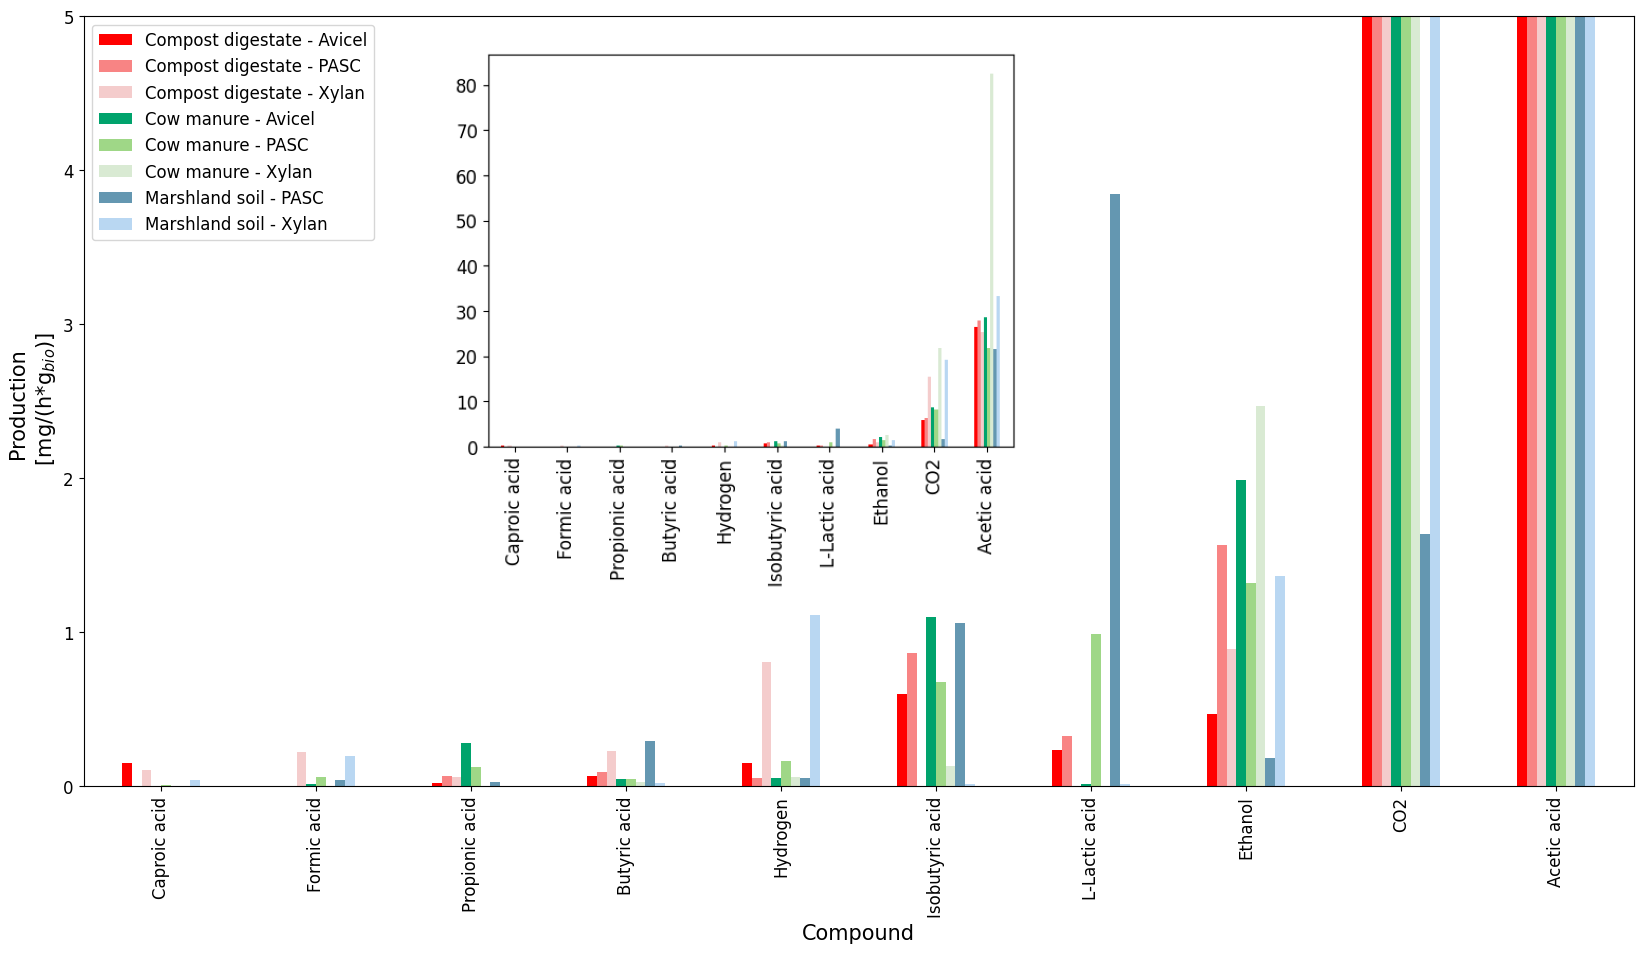

In [12]:
fig, ax = plt.subplots()
im = plt.imread("Figures/comm_prod_temporary.png")



steadier_sample_prod_plot_df.plot(ax=ax,kind="bar",figsize=(20,10),cmap=cmap_local,fontsize=12, rot=90,ylim=[0,5])
plt.legend(fontsize=12)
plt.xlabel('Compound', fontsize=15)
plt.ylabel('Production \n [mg/(h*g$_{bio}$)]', fontsize=15)

# Add inner axis
newax = fig.add_axes([0.2, 0.3, 0.5, 0.55], zorder=10)
newax.imshow(im)
newax.axis('off')


plt.savefig("Figures/community_production_bar.png",bbox_inches='tight')
plt.show()

In [13]:
steadier_sample_bar = steadier_sample.copy()
steadier_sample_production = steadier_sample_bar[steadier_sample_bar.receiver=="environment"].copy()
steadier_sample_production["community"]=steadier_sample_production["community"].map(lambda x:communityid2name_dict[x])
cmap_local = colors.ListedColormap([cmap_lut[community] for community in communityid2name_dict.keys()])

**Inner plot**

In [14]:
steadier_sample_prod_plot_df = steadier_sample_production.groupby(["community","compound"]).sum()["mass_rate*frequency"].unstack().fillna(0).T
steadier_prod_sum = steadier_sample_prod_plot_df.sum(axis=1)
sorter = steadier_prod_sum.sort_values().index
steadier_sample_prod_plot_df = steadier_sample_prod_plot_df.loc[sorter]
steadier_sample_prod_plot_df = steadier_sample_prod_plot_df.loc[steadier_sample_prod_plot_df.T.sum()>0.3]

In [15]:
steadier_sample_prod_plot_df.plot(kind="bar",cmap=cmap_local,fontsize=12, rot=90,legend=False)
plt.xlabel('')
plt.savefig("Figures/comm_prod_temporary.png",bbox_inches='tight')
plt.close()

**Outer plot**

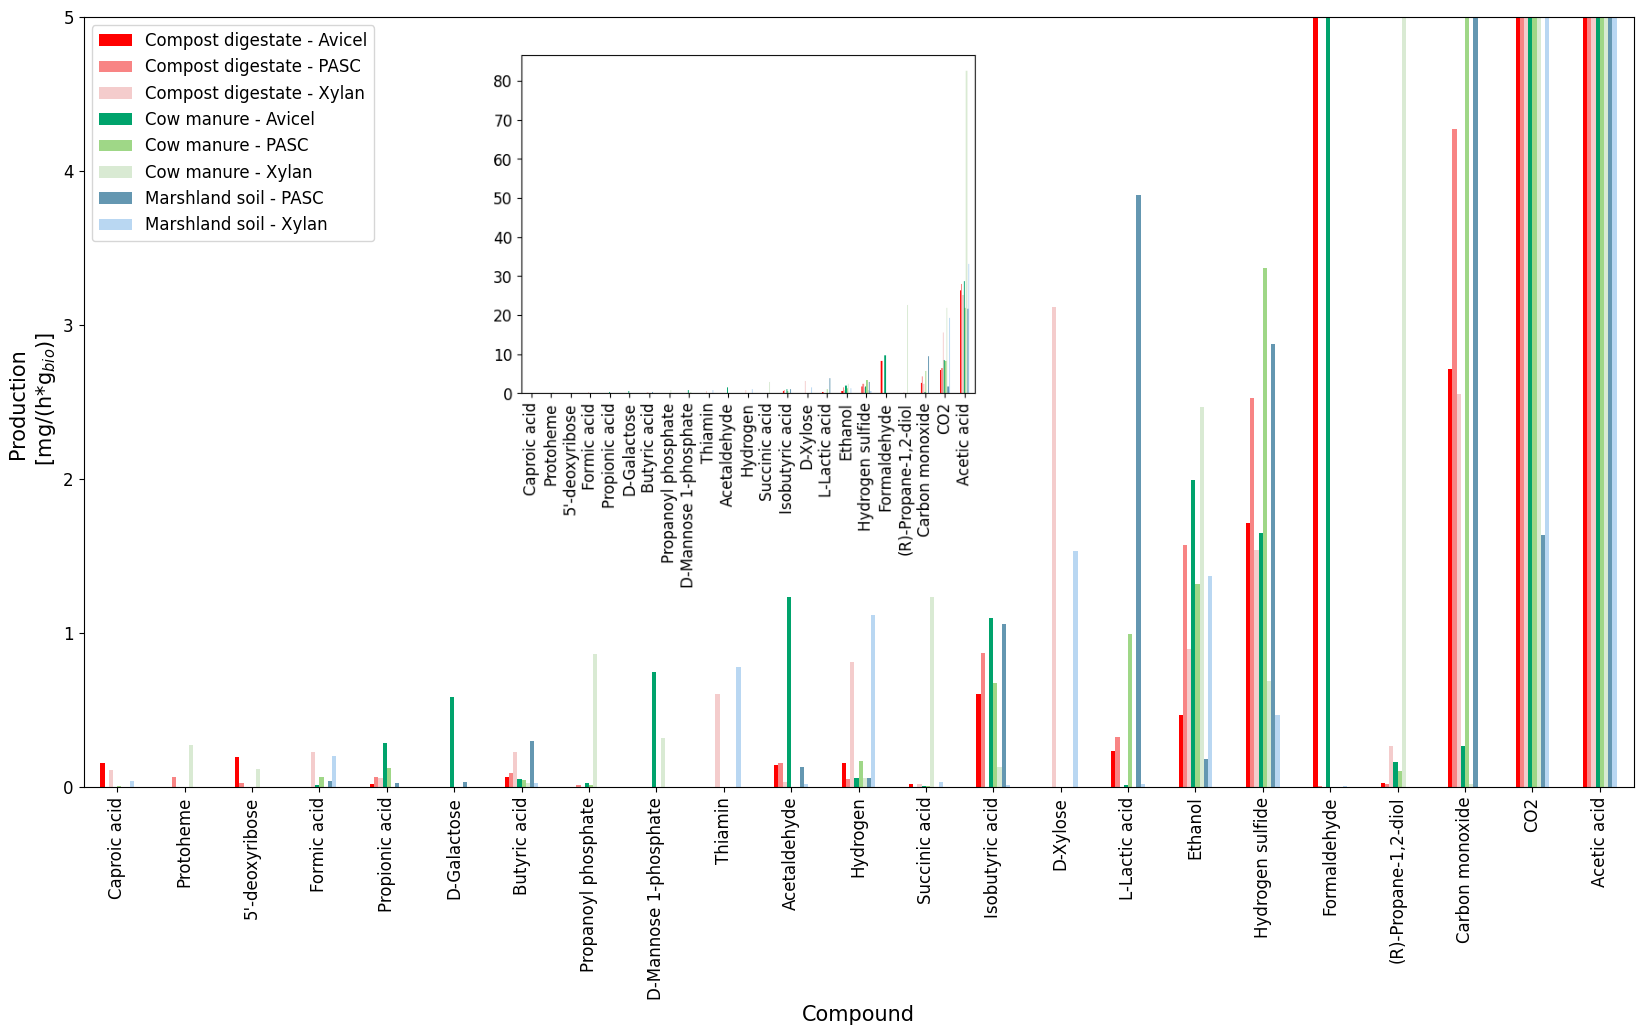

In [16]:
fig, ax = plt.subplots()
im = plt.imread("Figures/comm_prod_temporary.png")



steadier_sample_prod_plot_df.plot(ax=ax,kind="bar",figsize=(20,10),cmap=cmap_local,fontsize=12, rot=90,ylim=[0,5])
plt.legend(fontsize=12)
plt.xlabel('Compound', fontsize=15)
plt.ylabel('Production \n [mg/(h*g$_{bio}$)]', fontsize=15)

# Add inner axis
newax = fig.add_axes([0.2, 0.3, 0.5, 0.55], zorder=10)
newax.imshow(im)
newax.axis('off')


#plt.savefig("Figures/community_production_bar.png",bbox_inches='tight')
plt.show()

### Production - clustermaps

**Define colors**

In [17]:
color_df,relevant_phyla,phyla_lut = process_data.phylum_colors_spec(steadier_sample,all_mags_paper_reduced=all_mags_paper_reduced)

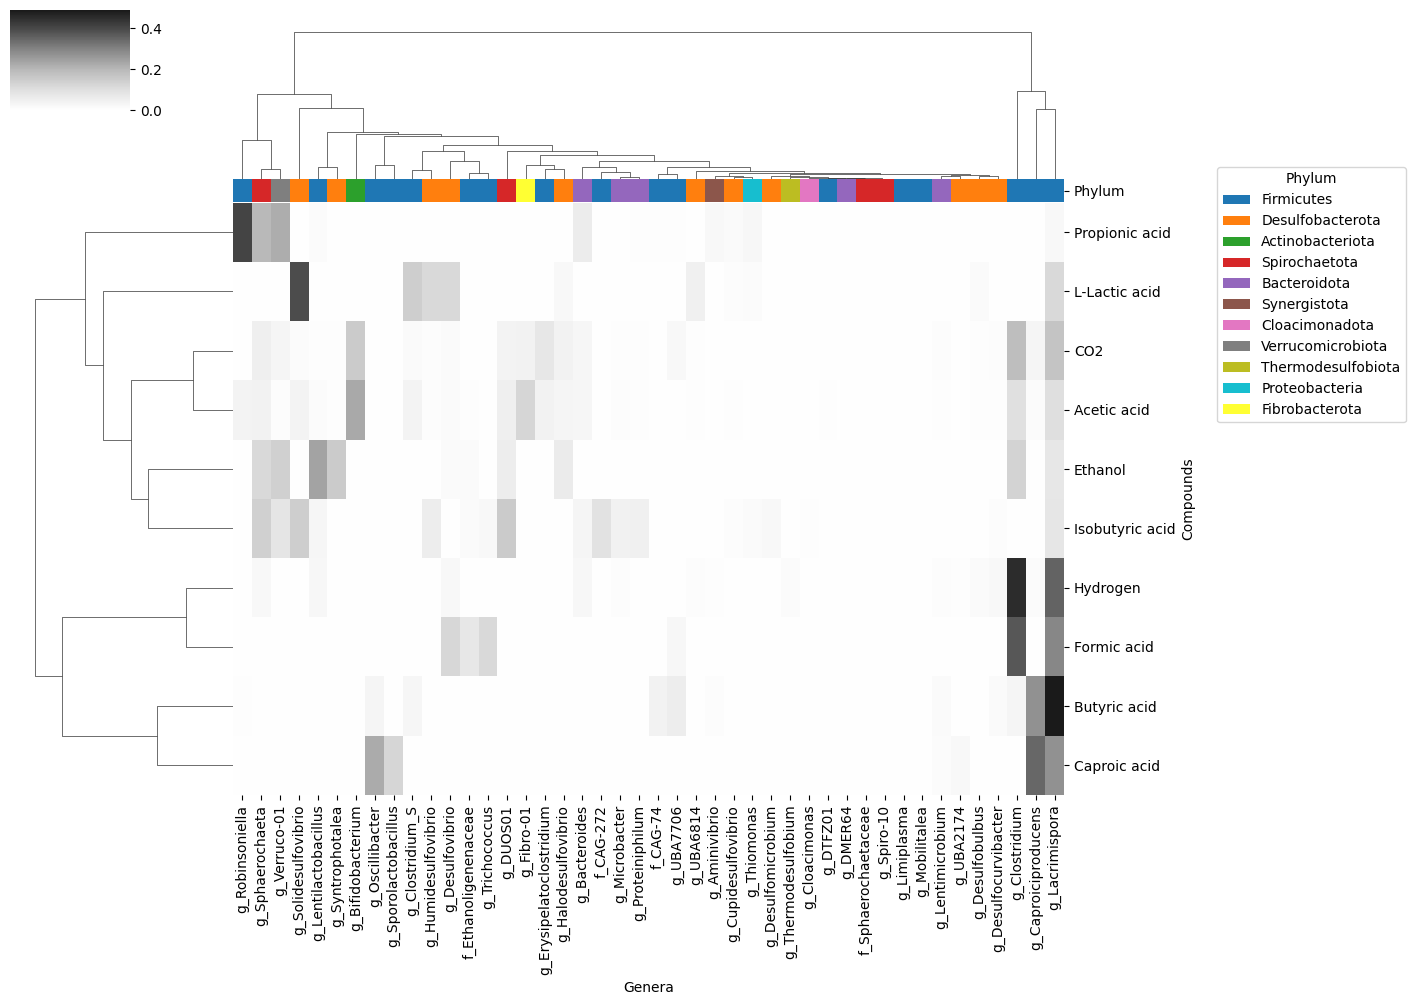

In [18]:
steadier_sample_not_from_env = steadier_sample[steadier_sample.donor!="environment"].copy()
steadier_sample_prod_overview = steadier_sample_not_from_env.groupby(["genus_donor","compound"]).sum()["mass_rate*frequency"].unstack().fillna(0)
# Missing 1-propanol
steadier_sample_prod_overview.index.name="Genera"
steadier_sample_prod_overview.columns.name="Compounds"
steadier_sample_prod_overview = steadier_sample_prod_overview[["CO2","Hydrogen","Acetic acid","Ethanol","Propionic acid","Butyric acid","L-Lactic acid","Formic acid","Caproic acid","Isobutyric acid"]]
steadier_sample_prod_overview = steadier_sample_prod_overview/steadier_sample_prod_overview.sum()

fig = sns.clustermap(data=steadier_sample_prod_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=None,
               yticklabels=True,
               xticklabels=True,
              figsize=(12,10),
              cbar_pos=(0,0.9,0.1,0.1))

for label in relevant_phyla:
    fig.ax_col_dendrogram.bar(0, 0, color=phyla_lut[label], label=label, linewidth=0)

l1 = fig.ax_col_dendrogram.legend(title='Phylum',ncol=1, bbox_to_anchor=(1.0, 0.85), loc='upper left',bbox_transform=gcf().transFigure)


fig.savefig("Figures/clustermap_prod_env_and_others.png",bbox_inches='tight')

## Interactions

In [19]:
steadier_sample_cross = steadier_sample[(steadier_sample.donor!="environment") & (steadier_sample.receiver!="environment")]

steadier_sample_cross = steadier_sample_cross[steadier_sample_cross.frequency>0.1]

### Interactions - community wise

In [20]:
def plot_interractions(steadier_sample,selected_compounds=False,interesting_superclasses=False,fig_title=False,min_number=0,count_or_sum="count",ylim_top=100,inset_plot=True):
    
    steadier_sample_pro = steadier_sample.copy()
    
    if interesting_superclasses:
        steadier_sample_pro = steadier_sample_pro[steadier_sample_pro.super_class.isin(interesting_superclasses)].copy()
    
    
    cmap_local = colors.ListedColormap([cmap_lut[community] for community in sorted(steadier_sample_pro.community.unique())])    
    if count_or_sum=="count":
        steady_com_count = steadier_sample_pro.groupby(["community","compound"]).count()["mass_rate*frequency"]
    elif count_or_sum=="sum":
        steady_com_count = steadier_sample_pro.groupby(["community","compound"]).sum()["mass_rate*frequency"]
    

    # Only allow members of selected categories to be involved (avoid minerals etc)
    if selected_compounds:
        steady_com_count = steady_com_count.reset_index()[steady_com_count.reset_index().compound.isin(chebi_interesting.index)].set_index(["community","compound"])
    steady_com_count.index.names = ("Community","Compound")
    steady_com_count = pd.DataFrame(steady_com_count)

    # prepare dataframe for plot
    all_compounds = steady_com_count.reset_index().groupby("Compound").sum()["mass_rate*frequency"]
    all_compounds=all_compounds[all_compounds>min_number].index  

    steady_com_count = steady_com_count.loc[(slice(None),list(all_compounds)),:]
    steady_com_count_for_plot = steady_com_count["mass_rate*frequency"].unstack(level=0).fillna(0)
    
    #Sort by the sum of the columns
    steady_com_count_for_plot = steady_com_count_for_plot.transpose()[steady_com_count_for_plot.sum(axis=1).sort_values().index].transpose()
    steady_com_count_for_plot = steady_com_count_for_plot.transpose().reset_index()
    steady_com_count_for_plot["Community"]=steady_com_count_for_plot["Community"].map(lambda x:communityid2name_dict[x])
    steady_com_count_for_plot = steady_com_count_for_plot.set_index("Community").transpose()
    
    
    
    if inset_plot:  
        ax = steady_com_count_for_plot.plot(kind="bar",figsize=(10,5),cmap=cmap_local,fontsize=12, rot=90,legend=False)
    
        plt.xlabel("")
    
        plt.savefig("Figures/interactions_bar_temporary.png",bbox_inches='tight')

        plt.close()


        fig, ax = plt.subplots()
        im = plt.imread("Figures/interactions_bar_temporary.png")

        steady_com_count_for_plot.plot(ax=ax,kind="bar",figsize=(20,10),cmap=cmap_local,fontsize=12, rot=90,ylim=[0,ylim_top])
    else:
        ax = steady_com_count_for_plot.plot(kind="bar",figsize=(20,10),cmap=cmap_local,fontsize=12, rot=90,legend=False)
    
        
    plt.legend(fontsize=12)
    plt.xlabel('Compounds', fontsize=15)

    if count_or_sum=="count":
        plt.ylabel("# of interactions",fontsize=15)

    elif count_or_sum=="sum":
        plt.ylabel("Interaction rate \n [mg/(h*g$_{bio}$)]",fontsize=15)
    
    if inset_plot:
        newax = fig.add_axes([0.15, 0.3, 0.7, 0.55], zorder=10)
        newax.imshow(im)
        newax.axis('off')


    plt.savefig("Figures/interactions_"+str(fig_title)+".png",bbox_inches='tight')
    plt.show()
    
    
    return steady_com_count_for_plot

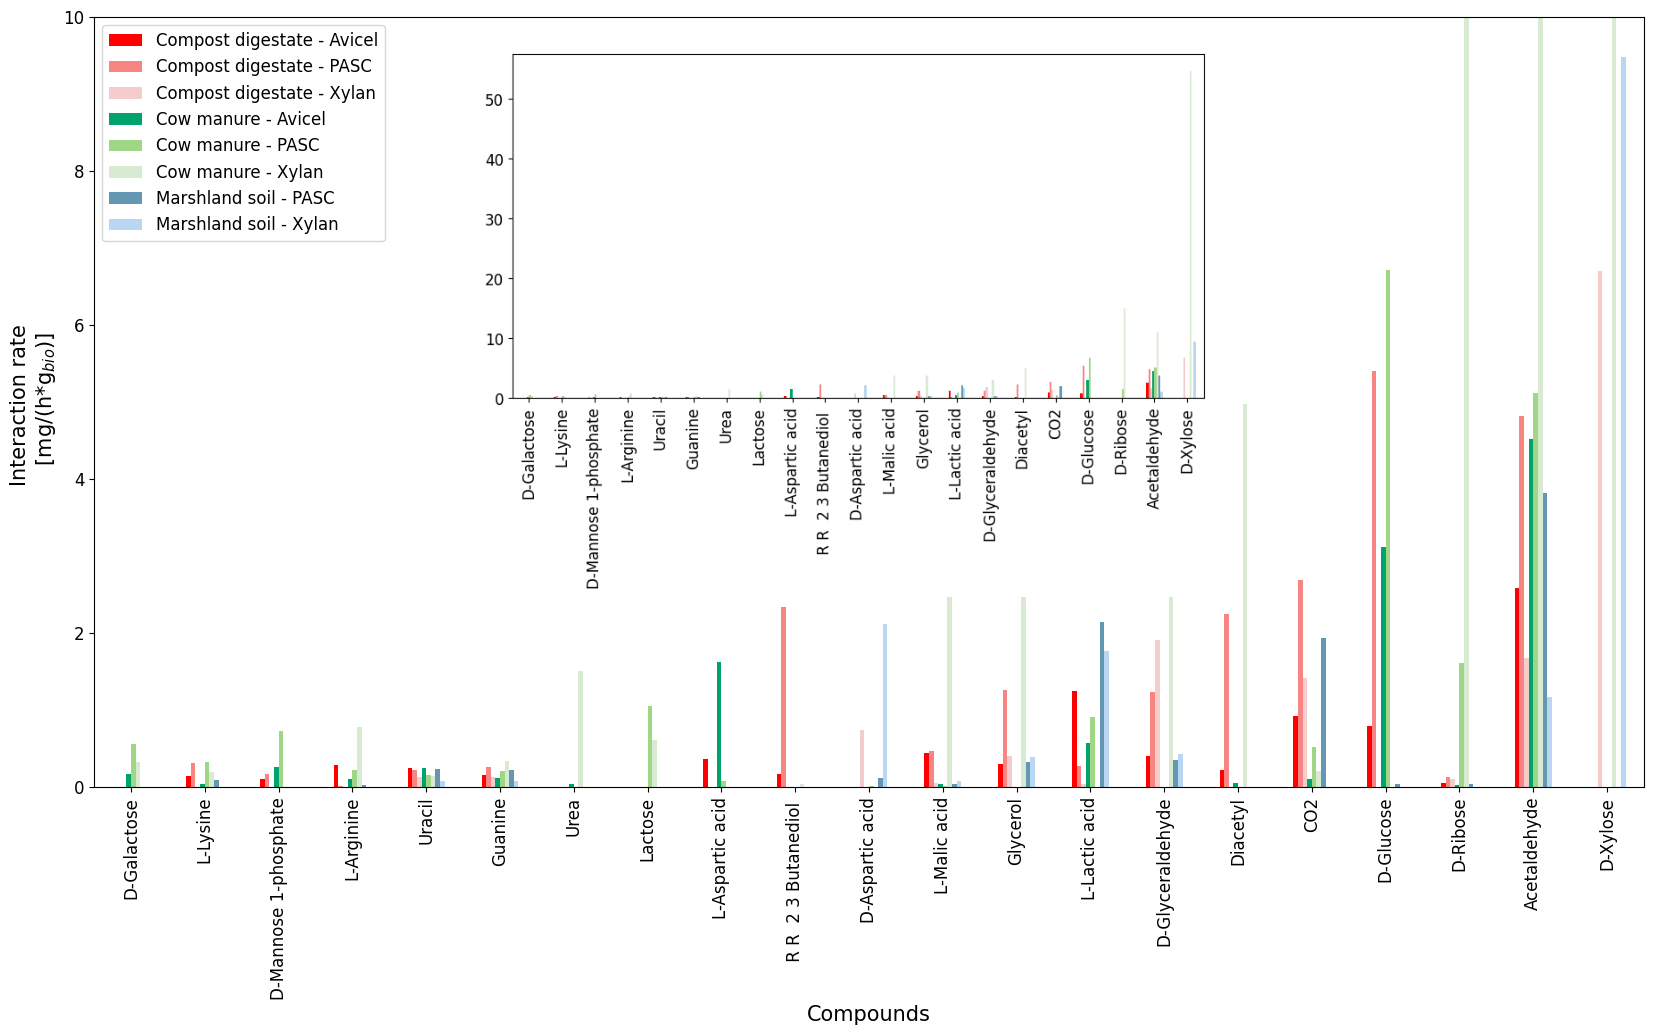

In [21]:
steady_com_count_for_plot = plot_interractions(steadier_sample_cross,min_number=1.0,fig_title="all",count_or_sum="sum",ylim_top=10)

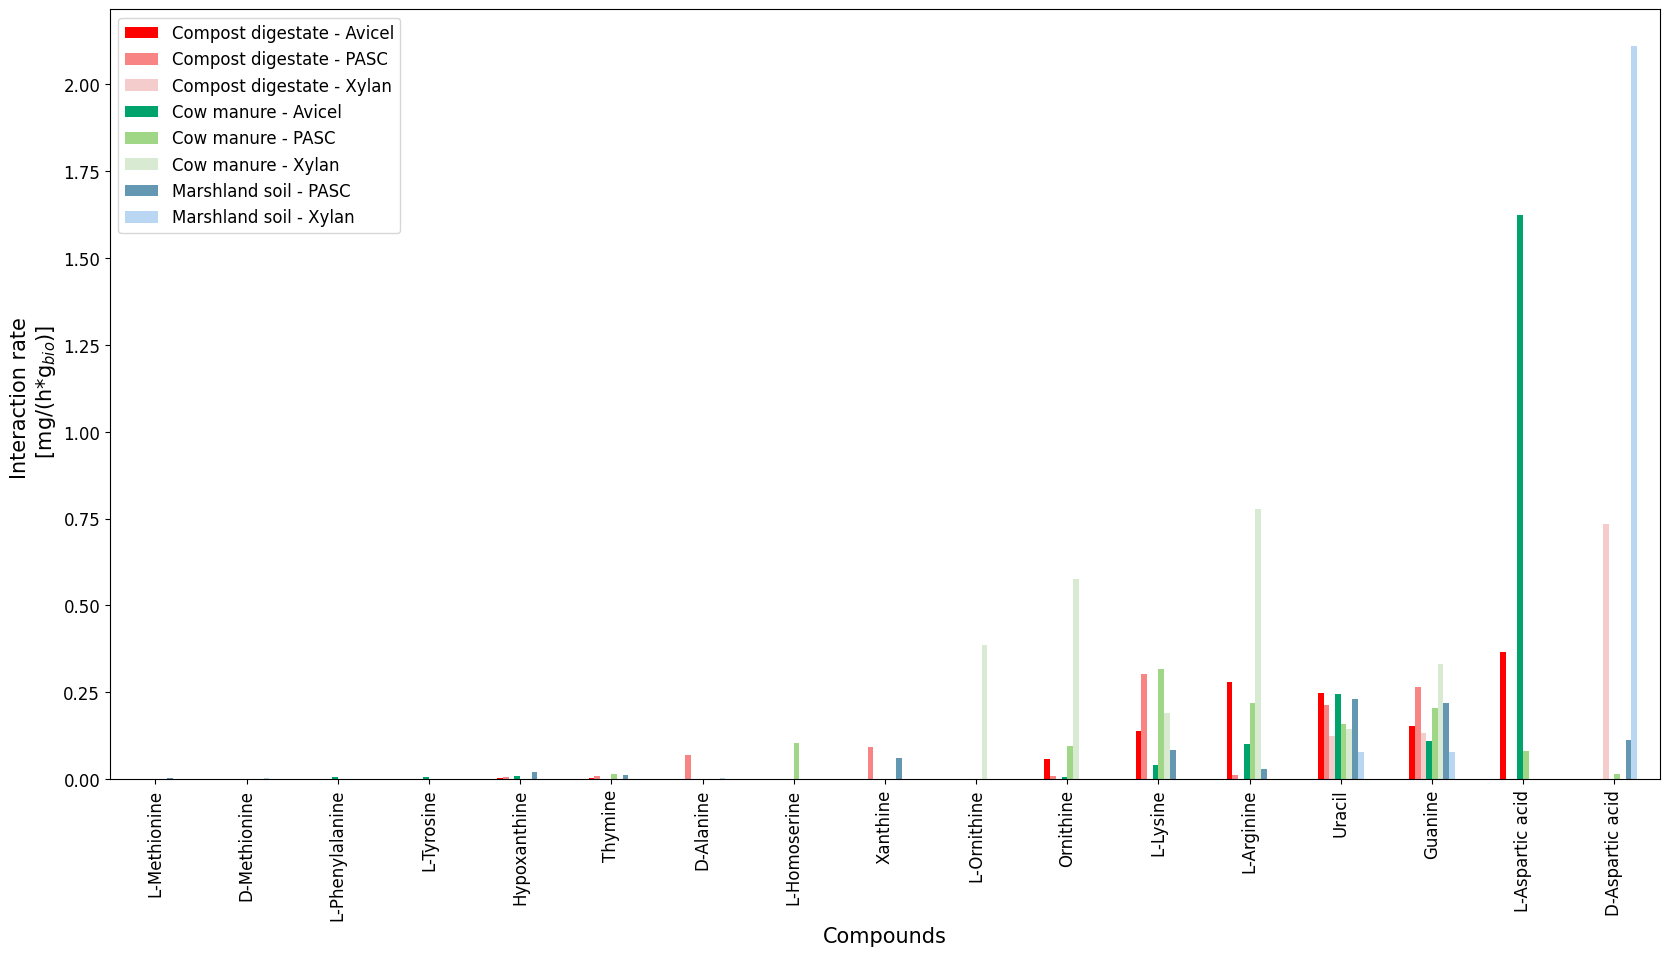

In [22]:
steady_com_count_for_plot = plot_interractions(steadier_sample_cross,
                                               interesting_superclasses=["nucleotides and derivatives","amino acids and derivatives","B-vitamins","urea and derivatives","cofactors"],
                                               fig_title="special_compounds", 
                                               count_or_sum="sum",
                                               ylim_top=1,
                                               inset_plot=False)

## Auxotrophies

##### Load models

In [23]:
MAG2community_id = pd.read_csv("../output_30_08_24/MAG2community_id.tsv",sep="\t",header=None)
MAG2community_id.columns=["MAG","community_id"]

In [24]:
CD_X_MAGs = MAG2community_id[MAG2community_id.community_id=="CD_X"].MAG.values

GEMs_dict = {}

for MAG in CD_X_MAGs:
    GEMs_dict[MAG]=reframed.load_cbmodel("../output_30_08_24/GEMs/GEMs_final/"+MAG+".xml", flavor="bigg")

In [25]:
media_db = pd.read_csv("https://raw.githubusercontent.com/cdanielmachado/carveme/master/carveme/data/input/media_db.tsv",sep="\t")
lb_db = media_db[media_db.medium=="LB[-O2]"]
m9_env_db = media_db[media_db.medium=="M9[-O2]"]
m9_env = reframed.Environment.from_compounds(m9_env_db.compound.values)
lb_env = reframed.Environment.from_compounds(lb_db.compound.values)
lb_env["R_EX_gua_e"]=(-1000,0)

all_gems_auxo={}

for MAG in GEMs_dict.keys():
    model = GEMs_dict[MAG]
    
    lb_env.apply(model,inplace=True,warning=False)
    specific_env = reframed.Environment.from_model(model)
    
    auxo = auxotrophy.auxotrophies(model,specific_env)
    
    all_gems_auxo[MAG]=auxo

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-14


In [26]:
summary_auxo = {}

for key,value in all_gems_auxo.items():
    summary_auxo[key]={}
    for rxn in value:
        summary_auxo[key][rxn]=1
summary_auxo_df = pd.DataFrame(summary_auxo).fillna(0)
summary_auxo_df = summary_auxo_df.loc[~summary_auxo_df.index.isin(["R_EX_"+met+"_e" for met in m9_env_db.compound.values])]

rxn2met = {rxn:model_uni.reactions[rxn].get_substrates()[0] for rxn in model.reactions if rxn.startswith("R_EX_")}
rxn2met["R_EX_nac_e"] = "M_nac_e"
rxn2met["R_EX_pnto__R_e"] = "M_pnto__R_e"
rxn2met["R_EX_ins_e"] = "M_ins_e"
rxn2met["R_EX_adn_e"] = "M_adn_e"
rxn2met["R_EX_gsn_e"] = "M_gsn_e"
rxn2met["R_EX_cmp_e"] = "M_cmp_e"

summary_auxo_df.index = summary_auxo_df.index.map(lambda x: model_uni.metabolites[rxn2met[x]].name)
summary_auxo_df.index = summary_auxo_df.index.map(lambda x: x.replace(" C17H20N4O6",""))


genus_groups,mag2genus_dict = general_func.mag2genus(all_mags_paper_reduced)
summary_auxo_df.columns = summary_auxo_df.columns.map(lambda x:mag2genus_dict[x])

In [28]:
colrs_df,phyla_specific,phyla_lut = process_data.color_df_auxotrophies(CD_X_MAGs,all_mags_paper_reduced)

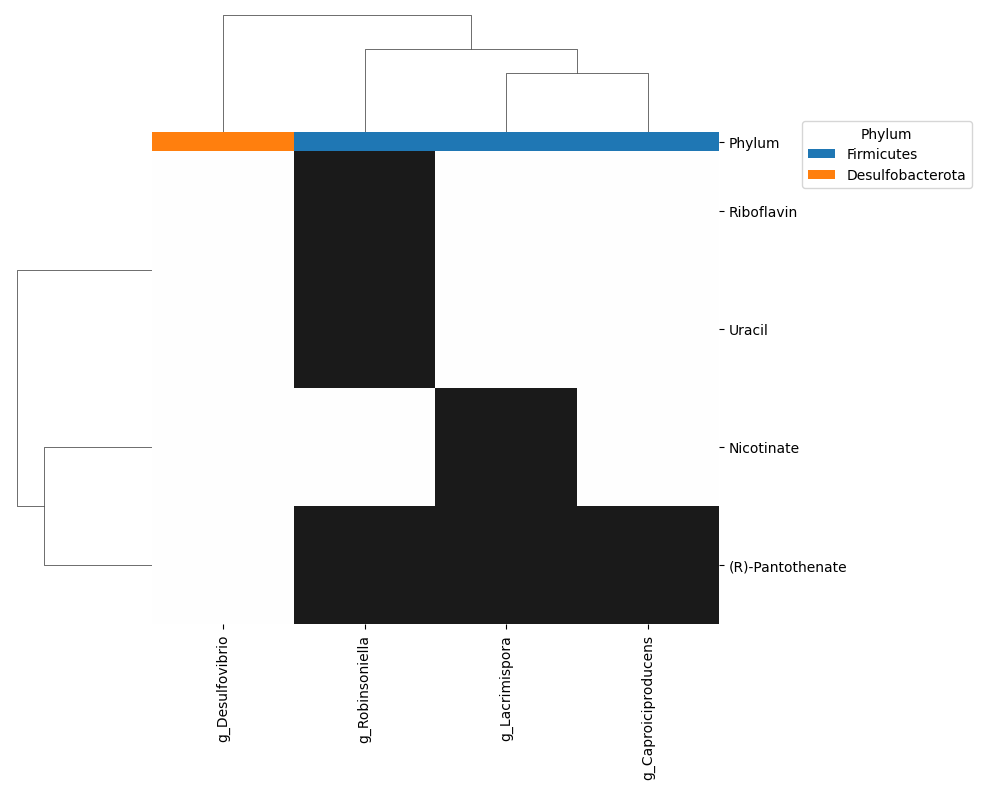

In [29]:
fig = sns.clustermap(data=summary_auxo_df, 
               cmap="RdGy",
               center=0,
               method="average",
               metric="jaccard",
               col_colors=colrs_df,
               z_score=None,
               cbar_pos=None,
               standard_scale=None,
               xticklabels=True,
               yticklabels=True,
               figsize=(8,8)             )
plt.setp(fig.ax_heatmap.get_yticklabels(),rotation=360) 


for label in phyla_specific:
    fig.ax_col_dendrogram.bar(0, 0, color=phyla_lut[label], label=label, linewidth=0)

l1 = fig.ax_col_dendrogram.legend(title='Phylum',ncol=1, bbox_to_anchor=(1.0, 0.85), loc='upper left',bbox_transform=gcf().transFigure)

fig.savefig("Figures/auxotrophies_CD_X.png",bbox_inches='tight')

In [ ]:
from matplotlib.colors import ListedColormap

In [ ]:
col_genus_unifyed = {
                     "Acidaminococcus": "#26FE0D",
                     "Agathobacter" : "#1C22FB",
                     "Anaerocolumna" : "#FCCCCE",
                     "Anaerostignum" : "#FF0DE0",
                     "Bacteroides" : "#0DFCE5",
                     "Bifidobacterium" : "#F2E700",
                     "Caproiciproducens" : "#165180",
                     "Cellulomonas" : "#FD8E22",
                     "Christensenellaceae R-7 group" : "#9E004D",
                     "Clostridium sensu stricto 1" : "#3D711C",
                     "Clostridium sensu stricto 11" : "#D088FA",
                     "Clostridium sensu stricto 2" : "#714000",
                     "Desulfobacter" : "#00A0FC",
                     "Desulfomicrobium" : "#BEE3FF",
                     "Desulfovibrio" : "#FB007F",
                     "DMER64" : "#8F4981",
                     "Dysgonomonas" : "#ADF57C",
                     "Enterococcus" : "#C6EBC4",
                     "Erysipelatoclostridium" : "#F8C278",
                     "Escherichia-Shigella" : "#C200FE",
                     "Eubacterium" : "#C92E16",
                     "Fibrobacter" : "#FF78CE",
                     "Hafnia-Obesumbacterium" : "#606663",
                     "Haloimpatiens" : "#F7928D",
                     "Incertae Sedis" : "#00FAA3",
                     "Lachnoclostridium" : "#512EB0",
                     "Lacticaseibacillus" : "#FDC2FF",
                     "Lelliottia" : "#0D9894",
                     "Lentilactobacillus" : "#00DEFF",
                     "Limosilactobacillus" : "#9E9C1C",
                     "Macellibacteroides" : "#9BA3EB",
                     "Microbacter" : "#B400B1",
                     "Mobilitalea" : "#FE26AF",
                     "Oscillibacter" : "#00AC78",
                     "Paludicola" : "#A4936C",
                     "Paucilactobacillus" : "#A9400D",
                     "Phascolarctobacterium" : "#FB6686",
                     "Proteiniphilum" : "#9F91B5",
                     "Rikenellaceae RC9 gut group" : "#22A30D",
                     "Robinsoniella" : "#9D65FB",
                     "Saccharofermentans" : "#E085AA",
                     "Schleiferilactobacillus" : "#83389F",
                     "Sphaerochaeta" : "#7F2A42",
                     "Sporolactobacillus" : "#F040FE",
                     "Streptococcus" : "#B26C00",
                     "Syntrophotalea" : "#0091C7",
                     "Thermodesulfobium" : "#EAE4A1",
                     "Treponema" : "#FB000D",
                     "Trichococcus" : "#98F90D",
                     "UCG-004" : "#9FF1E8",
                     "Verruc-01" : "#FEC80D"}
col_genus_unifyed = {"g_"+key:value for key, value in col_genus_unifyed.items()}
# c(" Genus < 5% abund." = "grey",

In [ ]:
ListedColormap(sorted(col_genus_unifyed.values()))

In [ ]:
set(total_members_genus.keys())-set(col_genus_unifyed.keys())

In [ ]:
set(col_genus_unifyed.keys()) - set(total_members_genus.keys())